In [181]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0,1'
import gc
import cv2
import time
import json
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from datetime import datetime
from multiprocessing import Value
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from logging.handlers import TimedRotatingFileHandler
from matplotlib import pyplot as plt
from matplotlib import cm
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from PIL import Image
import glob

# 1. load_model

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(device, True)
    except:
        print('set', device, 'error')
        pass

In [3]:
strategy = tf.distribute.MirroredStrategy(cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())
with strategy.scope():
    model_test = load_model('COG_ai_rebin/DM_MF/IRV2_die_saw_gary_10timesOK__2022-10-4/IRV2_die_saw_gary_10timesOK_best_acc.h5')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [4]:
model_test.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 111, 111, 32) 288         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 111, 111, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 111, 111, 32) 0           batch_normalization_203[0][0]    
____________________________________________________________________________________________

# 2. define heatmap function

In [187]:
class GenHeatMap():
    def __init__(self, model):
        self.model=model
        self.gradcam=GradcamPlusPlus(model ,model_modifier=ReplaceToLinear(), clone=True)
    
    def start(self,array,index,layer,save=False):
        for arr in array:
            cam = self.gradcam(CategoricalScore(index), arr, penultimate_layer=layer)
            
            if arr.shape[-1]==1:
                plt.imshow(arr, cmap='gray')
            else :
                plt.imshow(img)
                
            heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
            plt.imshow(heatmap, cmap='jet', alpha=0.5)
            
            if save==True:
                plt.savefig('output/' + str(layer) + '.png')
                plt.clf()
                
            else :
                plt.show()
                
    def save_each_layer(self,array,index):
        print('total layer=',len(self.model.layers))
        for i in range(len(self.model.layers)):
            if isinstance(self.model.layers[i], keras.layers.Conv2D):
                self.start(array,index,i,save=True)
                print(f'layer-{i} is saved.')

In [188]:
def loadData(paths_list):
    imag_array = np.zeros((len(paths_list),224,224,1),dtype=np.float32)
    for i in range(len(paths_list)):
        img = cv2.imread(paths_list[i])
        img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        imag_array[i,:,:,0] = (cv2.resize(img, (224, 224), interpolation = cv2.INTER_CUBIC))/255
    print(imag_array.shape)
    return imag_array

# 3. read_excel : fullPath -> np.array

In [7]:
df=pd.read_excel('COG_ai_rebin/DM_MF/IRV2_die_saw_gary_10timesOK__2022-10-4/result.xlsx')
df

,Unnamed: 0,fullPath,fileName,date,class,defect,recipe,lot,wafer,die,rotation,confidence
0,0,/tf/cp1ai01/COG/03_POC訓練資料/DM/test_set/OK/切割道/...,DMZCB3-R27DMQ4-031-(+0186+0006)-181.JPG,test_set,OK,切割道,DMZCB3,R27DMQ4,031,(+0186+0006),NaN,7.554559e-09
1,1,/tf/cp1ai01/COG/03_POC訓練資料/DM/test_set/OK/切割道/...,DMZCB3-R27DMQ4-033-(+0147+0002)-429.JPG,test_set,OK,切割道,DMZCB3,R27DMQ4,033,(+0147+0002),NaN,2.078264e-08
2,2,/tf/cp1ai01/COG/03_POC訓練資料/DM/test_set/OK/切割道/...,DMBDA1-RA2DMB9-031-(+0062+0001)-022.JPG,test_set,OK,切割道,DMBDA1,RA2DMB9,031,(+0062+0001),NaN,2.543100e-08
3,3,/tf/cp1ai01/COG/03_POC訓練資料/DM/test_set/OK/切割道/...,DMFDH1-P53DMCE-030-(+0301+0006)-050.JPG,test_set,OK,切割道,DMFDH1,P53DMCE,030,(+0301+0006),NaN,2.318308e-07
4,4,/tf/cp1ai01/COG/03_POC訓練資料/DM/test_set/OK/切割道/...,DMASA1-RA2DMC8-007-(+0135+0006)-015.JPG,test_set,OK,切割道,DMASA1,RA2DMC8,007,(+0135+0006),NaN,2.070365e-10
...,...,...,...,...,...,...,...,...,...,...,...,...
12995,12995,/tf/cp1ai01/COG/03_POC訓練資料/DM/test_set/NG/刮傷/D...,DMASA1-R26DMCS-010-(+0002+0003)-005.JPG,test_set,NG,刮傷,DMASA1,R26DMCS,010,(+0002+0003),NaN,4.730081e-10
12996,12996,/tf/cp1ai01/COG/03_POC訓練資料/DM/test_set/NG/刮傷/D...,DMASA1-R26DMCS-010-(+0013+0002)-030.JPG,test_set,NG,刮傷,DMASA1,R26DMCS,010,(+0013+0002),NaN,1.558454e-09
12997,12997,/tf/cp1ai01/COG/03_POC訓練資料/DM/test_set/NG/刮傷/D...,DMASA1-R26DMCS-010-(+0017+0002)-035.JPG,test_set,NG,刮傷,DMASA1,R26DMCS,010,(+0017+0002),NaN,1.251772e-10
12998,12998,/tf/cp1ai01/COG/03_POC訓練資料/DM/test_set/NG/金凸塊形...,A-DMG9-P53DMCV-026-(+0029+0001)-006.JPG,test_set,NG,金凸塊形狀異常,DMG9,P53DMCV,026,(+0029+0001),NaN,1.102618e-04


In [12]:
tp_list=df[(df['defect']=="切割道")&(df['class']=="NG")&(df['confidence']>0.000001)].fullPath.values.tolist()
fp_list=df[(df['defect']=="切割道")&(df['class']=="NG")&(df['confidence']<0.000001)].fullPath.values.tolist()
print('tp_list=',len(tp_list))
print('fp_list=',len(fp_list))

tp_list= 15
fp_list= 3


# 4. draw heat map

In [189]:
tp_array=loadData(tp_list)
fp_array=loadData(fp_list)

(15, 224, 224, 1)
(3, 224, 224, 1)


In [190]:
heatmap_model=GenHeatMap(model_test)

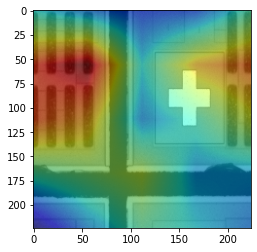

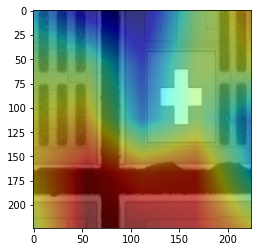

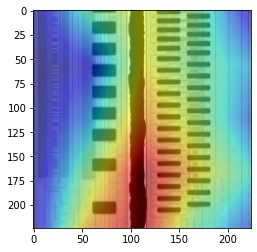

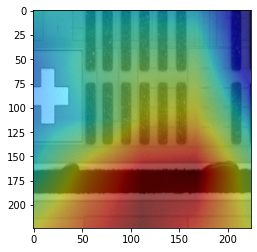

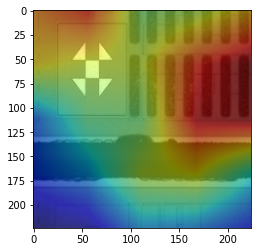

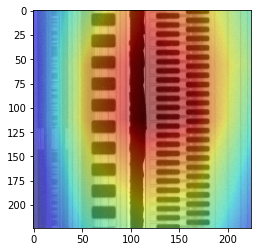

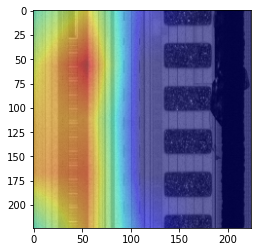

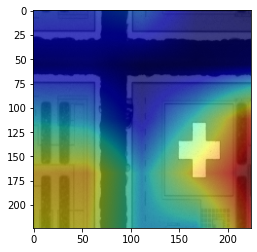

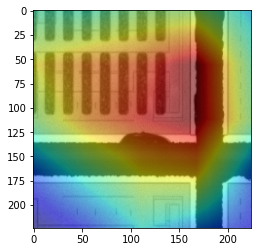

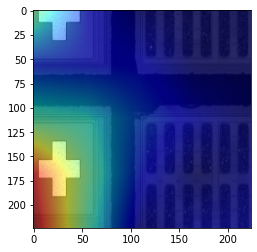

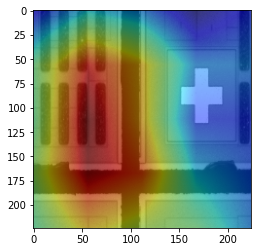

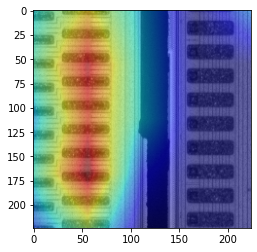

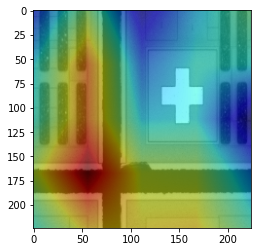

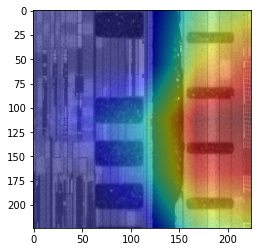

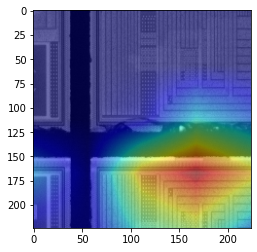

In [191]:
heatmap_model.start(tp_array,0,None)

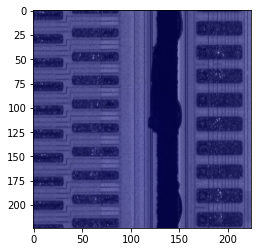

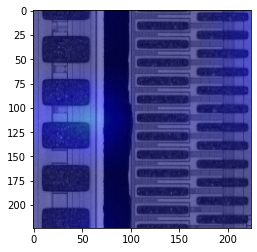

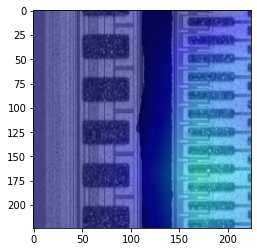

In [192]:
heatmap_model.start(fp_array,0,None)

# 4. generate gif

In [193]:
array0=loadData([tp_list[3]])

(1, 224, 224, 1)


In [194]:
heatmap_model.save_each_layer(array0,0)

total layer= 783
layer-1 is saved.
layer-4 is saved.
layer-7 is saved.
layer-11 is saved.
layer-14 is saved.
layer-18 is saved.
layer-21 is saved.
layer-22 is saved.
layer-28 is saved.
layer-29 is saved.
layer-30 is saved.
layer-31 is saved.
layer-41 is saved.
layer-44 is saved.
layer-45 is saved.
layer-50 is saved.
layer-51 is saved.
layer-52 is saved.
layer-60 is saved.
layer-63 is saved.
layer-66 is saved.
layer-67 is saved.
layer-72 is saved.
layer-73 is saved.
layer-74 is saved.
layer-82 is saved.
layer-85 is saved.
layer-88 is saved.
layer-89 is saved.
layer-94 is saved.
layer-95 is saved.
layer-96 is saved.
layer-104 is saved.
layer-107 is saved.
layer-110 is saved.
layer-111 is saved.
layer-116 is saved.
layer-117 is saved.
layer-118 is saved.
layer-126 is saved.
layer-129 is saved.
layer-132 is saved.
layer-133 is saved.
layer-138 is saved.
layer-139 is saved.
layer-140 is saved.
layer-148 is saved.
layer-151 is saved.
layer-154 is saved.
layer-155 is saved.
layer-160 is saved

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [195]:
img_in = "output/*.png"
gif_out = "output/sample.gif"

img, *imgs = [Image.open(f) for f in sorted(glob.glob(img_in))]
img.save(fp=gif_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)